In [1]:
### Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import gc

import torch
import torchvision
from torchinfo import summary
# print("PyTorch version:", torch.__version__)
# print("Torchvision version:", torchvision.__version__)
# print("CUDA is available:", torch.cuda.is_available())

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

## Load pre-trained SAM 

In [2]:
torch.cuda.empty_cache()
gc.collect()

# Check GPU memory usage at beginning
for i in range(torch.cuda.device_count()):     
    print('Total memory in GB: ', torch.cuda.get_device_properties(i).total_memory/(1.024*1e9))
    print('Memory reserved in GB: ', torch.cuda.memory_reserved(i)/(1.024*1e9))   # allocated + pre-cached
    print('Memory allocated in GB: ', torch.cuda.memory_allocated(i)/(1.024*1e9))   # actual memory used
    print("")

sam_checkpoint = "/mnt/hd1/ani/Liver_pathology_project/Segment_anything_model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")

# Print model summary
summary(model=sam,
        col_width=12,
        row_settings=["var_names"])

# Check GPU memory usage at end
for i in range(torch.cuda.device_count()):     
    print('Total memory in GB: ', torch.cuda.get_device_properties(i).total_memory/(1.024*1e9))
    print('Memory reserved in GB: ', torch.cuda.memory_reserved(i)/(1.024*1e9))
    print('Memory allocated in GB: ', torch.cuda.memory_allocated(i)/(1.024*1e9))

Total memory in GB:  24.83328
Memory reserved in GB:  0.0
Memory allocated in GB:  0.0

Total memory in GB:  24.83328
Memory reserved in GB:  2.637824
Memory allocated in GB:  2.5698105


## Automatic mask generator

Total memory in GB:  24.83328
Memory reserved in GB:  2.637824
Memory allocated in GB:  2.5698105
No. of objects detected:  188



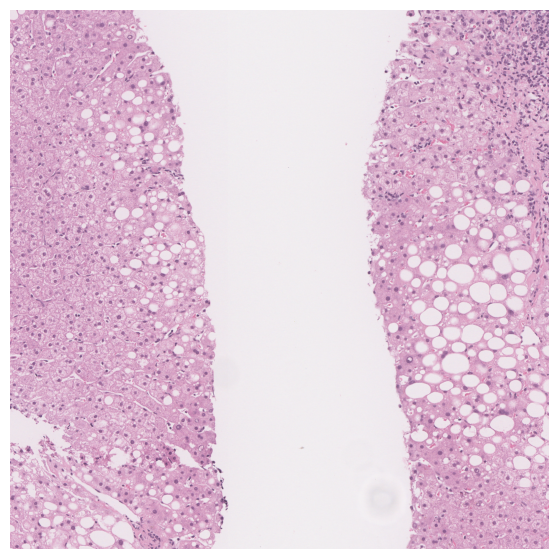

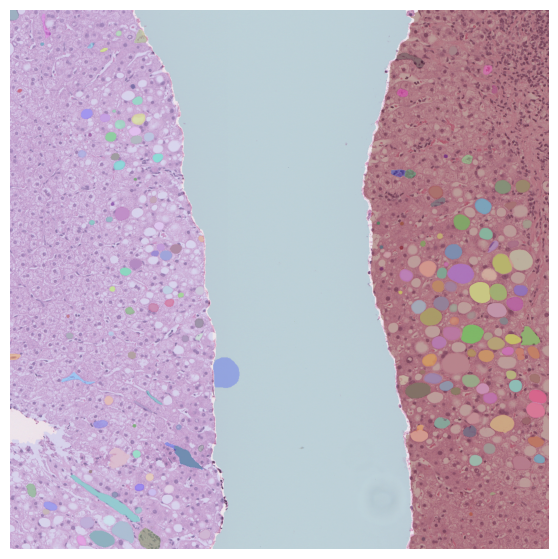

No. of objects detected:  70



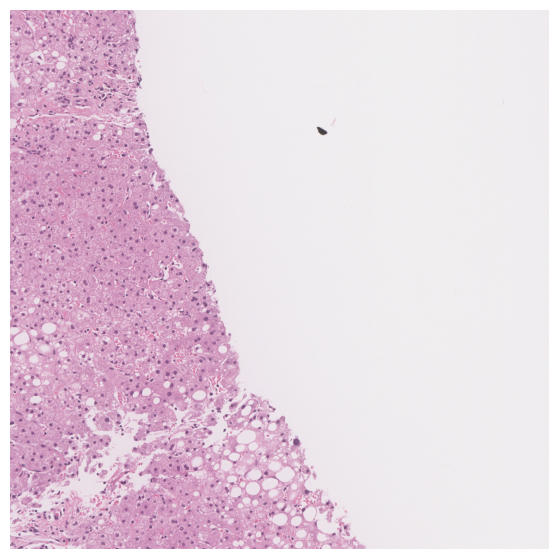

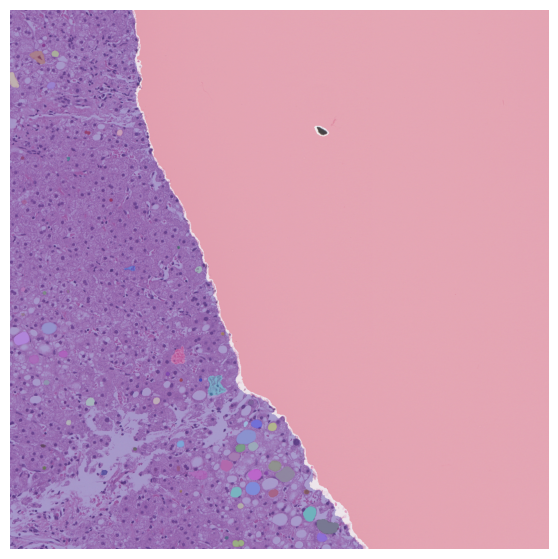

Total memory in GB:  24.83328
Memory reserved in GB:  6.418432
Memory allocated in GB:  2.5781305


In [3]:
torch.cuda.empty_cache()
gc.collect()

# Check GPU memory usage at beginning
for i in range(torch.cuda.device_count()):     
    print('Total memory in GB: ', torch.cuda.get_device_properties(i).total_memory/(1.024*1e9))
    print('Memory reserved in GB: ', torch.cuda.memory_reserved(i)/(1.024*1e9))
    print('Memory allocated in GB: ', torch.cuda.memory_allocated(i)/(1.024*1e9))

### Loading test image
path_test_imgs = '/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/NASH/104/'
test_imgs_list = (glob.glob(path_test_imgs + "*.png"))
# test_imgs_list

for i in range(1):

    img = cv2.imread(test_imgs_list[i])  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print(img.shape)   # (M x N x 3)

    #There are several tunable parameters in automatic mask generation that control 
    # how densely points are sampled and what the thresholds are for removing low 
    # quality or duplicate masks. Additionally, generation can be automatically 
    # run on crops of the image to get improved performance on smaller objects, 
    # and post-processing can remove stray pixels and holes. 
    # Here is an example configuration that samples more masks:
    #https://github.com/facebookresearch/segment-anything/blob/9e1eb9fdbc4bca4cd0d948b8ae7fe505d9f4ebc7/segment_anything/automatic_mask_generator.py#L35    

    #Rerun the following with a few settings, ex. 0.86 & 0.9 for iou_thresh
    # and 0.92 and 0.96 for score_thresh
    mask_generator_ = SamAutomaticMaskGenerator(model=sam, 
                                                points_per_side=32, 
                                                pred_iou_thresh=0.9, 
                                                stability_score_thresh=0.96, 
                                                crop_n_layers=1, 
                                                crop_n_points_downscale_factor=2, 
                                                min_mask_region_area=100)  # Requires open-cv to run post-processing

    # Resizing image to fit into GPU memory
    img = cv2.resize(img, (1024, 1024))

    masks = mask_generator_.generate(img)
    print('No. of objects detected: ', len(masks))
    print("")

    ### Visualization
    def show_anns(anns):
        if len(anns) == 0:
            return
        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
        ax = plt.gca()
        ax.set_autoscale_on(False)
        polygons = []
        color = []
        for ann in sorted_anns:
            m = ann['segmentation']
            img = np.ones((m.shape[0], m.shape[1], 3))
            color_mask = np.random.random((1, 3)).tolist()[0]
            for i in range(3):
                img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, m*0.35)))

    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.axis('off')
    # plt.show()
    # plt.savefig(f"/mnt/hd1/ani/Liver_pathology_project/Results/SAM/104_63_135.png")

    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    show_anns(masks)
    plt.axis('off')
    plt.show() 
    # plt.savefig(f"/mnt/hd1/ani/Liver_pathology_project/Results/SAM/104_63_135_SAM.png")

    '''
    Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

    segmentation : the mask
    area : the area of the mask in pixels
    bbox : the boundary box of the mask in XYWH format
    predicted_iou : the model's own prediction for the quality of the mask
    point_coords : the sampled input point that generated this mask
    stability_score : an additional measure of mask quality
    crop_box : the crop of the image used to generate this mask in XYWH format

    '''

# Check GPU memory usage at end
for i in range(torch.cuda.device_count()):     
    print('Total memory in GB: ', torch.cuda.get_device_properties(i).total_memory/(1.024*1e9))
    print('Memory reserved in GB: ', torch.cuda.memory_reserved(i)/(1.024*1e9))
    print('Memory allocated in GB: ', torch.cuda.memory_allocated(i)/(1.024*1e9))